<a href="https://colab.research.google.com/github/MengxuanMa2016/Credit-Card-Fraud-Detection/blob/master/Credit_Card_Fraud_Detection_Feature_Engineering_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(100)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load the credit card dataset
link:  https://data.world/vlad/credit-card-fraud-detection

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# list data files are available in the data directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

path = "/content/gdrive/My Drive/credit_card_fraud_detection/"

from subprocess import check_output
print(check_output(["ls", path]).decode("utf8"))

# Any results you write to the current directory are saved as output.

CC.csv
Credit_Card_Fraud_Detection-Exploratory_Data_Analysis.ipynb
Credit_Card_Fraud_Detection-Feature_Engineering_Modeling.ipynb



In [4]:
transactions = pd.read_csv(path + "CC.csv")

# Time Feature is number of seconds elapsed between this transaction and the first transaction in the dataset
# Normalized the tiem feature by days
transactions["Time"] = transactions["Time"].apply(lambda x : x / 3600 % 24)
transactions.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
non_fraud = transactions[transactions['Class'] == 0].sample(10000)
fraud = transactions[transactions['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
features = df.drop(['Class'], axis = 1).values
labels = df["Class"].values

## Extract low-level represetation using an autoencoder network

An autoencoder network is a neural network architectures in which the output is same as the input. Autoencoders can be used to learn the low level repersentations of the input data. 

An autoencoder model is created to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases.

In [6]:
## input layer 
input_layer = Input(shape=(features.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(features.shape[1], activation='relu')(decoded)

W0729 06:27:32.435957 140485536561024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 06:27:32.455910 140485536561024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 06:27:32.461904 140485536561024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [7]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

W0729 06:27:32.548448 140485536561024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [8]:
x = transactions.drop(["Class"], axis=1)
y = transactions["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]
print("Total number of non-fraud transactions: " + str(x_norm.shape[0]))
print("Total number of fraud transactions: " + str(x_fraud.shape[0]))

Total number of non-fraud transactions: 284315
Total number of fraud transactions: 492


In [9]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 100, 
                shuffle = True, validation_split = 0.20);

W0729 06:27:33.083178 140485536561024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0729 06:27:33.091138 140485536561024 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1600 samples, validate on 400 samples
Epoch 1/100
1600/1600 [==============================] - 0s 220us/step - loss: 0.6914 - val_loss: 0.4275
Epoch 2/100
1600/1600 [==============================] - 0s 21us/step - loss: 0.3883 - val_loss: 0.2558
Epoch 3/100
1600/1600 [==============================] - 0s 16us/step - loss: 0.2459 - val_loss: 0.1834
Epoch 4/100
1600/1600 [==============================] - 0s 16us/step - loss: 0.1912 - val_loss: 0.1564
Epoch 5/100
1600/1600 [==============================] - 0s 28us/step - loss: 0.1722 - val_loss: 0.1690
Epoch 6/100
1600/1600 [==============================] - 0s 17us/step - loss: 0.1691 - val_loss: 0.1281
Epoch 7/100
1600/1600 [==============================] - 0s 24us/step - loss: 0.1323 - val_loss: 0.1182
Epoch 8/100
1600/1600 [==============================] - 0s 19us/step - loss: 0.1546 - val_loss: 0.1217
Epoch 9/100
1600/1600 [==============================] - 0s 19us/step - loss: 0.1320 - val_loss: 0.1263
Epoch 10/100
160

## Extract the latent representations
Extract the latent representations of the input learned by the model. 
Create another network and add the first three layers with trained weights. The output is the representations. 

In [0]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [11]:
norm_hid_rep = hidden_representation.predict(x_norm[:15000])
fraud_hid_rep = hidden_representation.predict(x_fraud)
print(norm_hid_rep.shape)

(15000, 50)


In [12]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
print(rep_x.shape)

(15492, 50)


##Visualization of the latent representations of fraud and non-fraud transactions

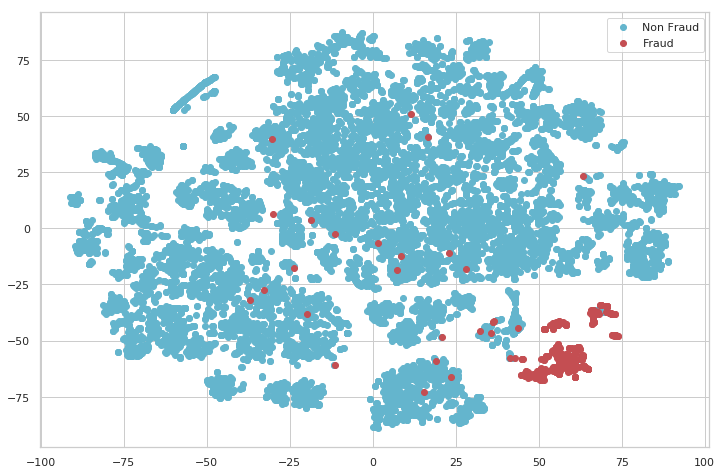

In [13]:
def tsne_plot(X, Y):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(X)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(Y == 0), 0], X_t[np.where(Y == 0), 1], marker='o', color='c', label='Non Fraud')
    plt.scatter(X_t[np.where(Y == 1), 0], X_t[np.where(Y == 1), 1], marker='o', color='r', label='Fraud')

    plt.legend(loc='best')
    plt.show()
    
tsne_plot(rep_x, rep_y)

From the figure above, we can see that the fraud and non-fraud classes are more linearly separable.

## Logistic regression model for fraud transaction classification

In [14]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3761
         1.0       0.96      0.78      0.86       112

    accuracy                           0.99      3873
   macro avg       0.97      0.89      0.93      3873
weighted avg       0.99      0.99      0.99      3873


Accuracy Score:  0.9925122643945262
